# A contracting cube

**Joakim Sundnes**

Date: **June 2024**


## Model outline
This notebook introduces a slight extension of the simple unit cube model introduced previously. The model will still be a simple unit cube, fixed at one end ($x=0$) and loaded with a pressure load (negative pressure, i.e. stretch) at the other end ($x=1.0$). The following two extensions will be introduced:
* Replace the StVenant-Kirchhoff model with a model from Guccione et al (1995). 
* Add a time-varying active stress to the model

### The material model by Guccione et al

Soft biological tissues typically follow an exponential stress-strain relation. This relation was originally described by Fung, and has been implemented in a wide range of models for isotropic and anisotropic tissues. One of the most widely used material models for passive cardiac tissue is the model of Guccione et al from 1995. Several versions of the model have been used in the literature. We apply a transversely isotropic and nearly incompressible version, with strain energy given by:
$$
\begin{align*}
Q &= b_f E_{11}^2 + b_t (E_{22}^2 + E_{33}^2 + E_{23}^2 + E_{32}^2) + b_{fs}(E_{12}^2 + E_{21}^2 + E_{13}^2 + E_{31}^2),\\
\Psi &= \frac{C}{2}(e^Q-1)+ \kappa(J\ln(J)-J+1)  .
\end{align*}
$$
Here $E_{ij}$ are the components of the Green-Lagrange strain tensor, defined relative to the local fiber orientation. Furthermore $J$ is the determinant of the deformation gradient $F$ ($J=1$ for an incompressible material), and $C,B_f,b_t,b_{fs}, \kappa$ are material parameters. 

### Setting up the Fenics solver
The bulk of the solver code will be identical to the first version of the unit cube. First, the usual imports, defining the mesh, the relevant function space and functions, and finally the Neumann and Dirichlet boundary conditions:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from fenics import *

# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 4


# Setup the mesh and the function space for the solutions
mesh = UnitCubeMesh(4,4,4)
V = VectorFunctionSpace(mesh, "Lagrange", 2)


# Define functions
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Mark boundary subdomains
left =  CompiledSubDomain("near(x[0], side) && on_boundary", side = 0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side = 1.0)

boundary_markers = MeshFunction("size_t", mesh,mesh.topology().dim() - 1)
boundary_markers.set_all(0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)

# Redefine boundary measure
ds = Measure('ds',domain=mesh,subdomain_data=boundary_markers)

# Define Dirichlet boundary (x = 0 or x = 1)
clamp = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, clamp, left)
bcs = [bc]

Next, we turn to defining the mechanics problem. The following code cell is identical to the exercise from yesterday, and goes through the following steps:
* Define the relevant kinematics
* Define the strain energy function
* Define the weak form, including the boundary conditions defined above
* Solve the problem with a for loop, gradually increasing the load
* Store the solution for plotting in Paraview, and plot the displacement in a single point



No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.455e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.187e-01 (tol = 1.000e-10) r (rel) = 6.331e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.950e-03 (tol = 1.000e-10) r (rel) = 2.880e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.126e-04 (tol = 1.000e-10) r (rel) = 3.258e-04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.776e-08 (tol = 1.000e-10) r (rel) = 5.142e-08 (tol = 1.000e-09)
  Newton iteration 5: r (

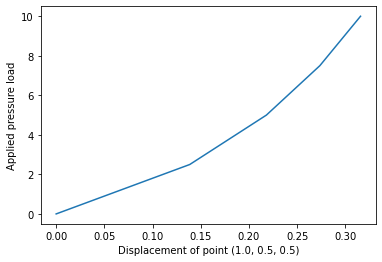

In [3]:
# Kinematics
d = len(u)
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
F = variable(F)
C = F.T*F                   # the right Cauchy-Green tensor
E = 0.5*(C - I)             # the Green-Lagrange strain tensor

# Material parameters (Lamé parameters)
mu    = 4.0  
lmbda = 20.0  

# The strain energy for the St-Venant Kirchhoff model:
psi = lmbda / 2 * (tr(E)**2) + mu * tr(E * E)
P = diff(psi, F)

p_right = Constant(0.0) #the pressure load (zero for now)

# Definition of the weak form:
N = FacetNormal(mesh)
Gext = p_right * inner(v, det(F) * inv(F) * N) * ds(2) #ds(2) = left boundary
R = inner(P,grad(v)) * dx + Gext 

#Finally, we solve the problem for different loads, and plot the load vs displacement. 
# The middle point on the right boundary
point0 = np.array([1.0,0.5,0.5])

# Step-wise loading (for plotting and convergence)
load_steps = 5
target_load = 10.0
loads = np.linspace(0, target_load, load_steps)

d0 = np.zeros(3)                #displacement at point0
disp = np.zeros(load_steps) #array to store displacement for all steps

disp_file = XDMFFile("displacement/u.xdmf")

for step in range(load_steps):
    # Stretch is a negative pressure
    p_right.assign(-loads[step])
    
    #solve the problem:
    solve(R == 0, u, bcs)
    
    #evaluate displacement at point defined above
    u.eval(d0,point0)
    disp[step] = d0[0]

    disp_file.write_checkpoint(u, "Displacement", step, append=True)

disp_file.close()

#displacement on x-axis, load on y-axis
plt.figure(1)
plt.plot(disp,loads)
plt.xlabel('Displacement of point (1.0, 0.5, 0.5)')
plt.ylabel('Applied pressure load')

plt.show()

## Step 1: Replace the StVenant-Kirchhoff material model
Modify the code above to use the Guccione material model. You can implement the strain energy function directly yourself, or you can use an existing Python class which can be found here:

* [Guccione model (1995)](./guccionematerial.py)

The class supports both fully incompressible and nearly incompressible models. The key part is the function named `strain_energy`, which defines the strain energy as a function of the deformation gradient $F$. 

An important difference between the StVenant-Kirchhoff material and the Guccione model is that the Guccione model is anisotropic, meaning that the material properties are different in different directions. The material model therefore needs to know about the local tissue microstructure, i.e., the orientation of the fiber-, sheet- and sheet normal directions. For flexibility and generality, our material model class takes these vectors (or vector fields) as input parameters, as can be seen in the class' constructor.  

In our simple unit cube, it is natural to define the fiber direction as parallel with the x-axis, the sheet direction parallel with the y-axis, and the normal direction parallel with the z-axis. Code for defining these vectors can look as follows:

In [4]:
# Tissue microstructure
f0 = as_vector([ 1.0, 0.0, 0.0 ])
s0 = as_vector([ 0.0, 1.0, 0.0 ])
n0 = as_vector([ 0.0, 0.0, 1.0 ])

Add these code lines and the necessary calls to the Guccione model class in the code above, to replace the StVenant-Kirchhoff material model with the Guccione material. 

## Step 2: Add active contraction

Next, we want to add active contraction to the tissue cube. If we want to simulate a full cardiac cycle, a simple option would be to assign an active stress transient similar to the one output from the Rice et al model:

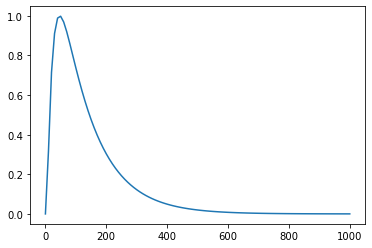

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

force_amplitude=1.0
#Ca_diastolic=0.09
start_time=5, 
tau1=20 
tau2=110
t = np.linspace(0,1000,101)

beta = -math.pow(tau1/tau2, -1/(1 - tau2/tau1)) + math.pow(tau1/tau2,\
        -1/(-1 + tau1/tau2))
force = ((force_amplitude)*(np.exp((start_time - t)/tau1) -\
        np.exp((start_time - t)/tau2))/beta) 

#the following line implements the if test in numpy without a loop
force = force*(t>=start_time)+ 0.0*(t<start_time)

plt.plot(t,force)
plt.show()

For now, we will keep things even simpler, and simply model the first phase of contraction by adding a linearly increasing active stress. For this case we consider an unloaded cube ($p=0$ on the right boundary). If you used the `GuccioneModel` class above to define the passive material properties, the active stress may be set in the function `set_active_stress`. 

A suitable definition of a linearly increasing active stress can be as follows:

In [5]:
# Step-wise loading (for plotting and convergence)
active_steps = 6
target_active = 5.0
active = np.linspace(0,target_active,active_steps)

Add these lines and a suitable call to the `set_active_stress` function to the code above, to make the cube contract actively.